In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
zeros = df[df.label == 0].drop('label', 1)
ones = df[df.label == 1].drop('label', 1) 
twos = df[df.label == 2].drop('label', 1) 
threes = df[df.label == 3].drop('label', 1) 
fours = df[df.label == 4].drop('label', 1) 
fives = df[df.label == 5].drop('label', 1) 
sixs = df[df.label == 6].drop('label', 1) 
sevens = df[df.label == 7].drop('label', 1) 
eights = df[df.label == 8].drop('label', 1) 
nines = df[df.label == 9].drop('label', 1) 

digit_list = [zeros,ones, twos, threes, fours, fives, sixs, sevens, eights, nines]

In [ ]:
# Part B
def show_digit(digit):
    sns.heatmap(data=pd.DataFrame(digit.head(1).values.reshape((28,28))))
    plt.show()

for digit in digit_list:
    show_digit(digit)

In [ ]:
# Part C
print np.histogram(df['label'], bins=np.arange(11), normed=True)[0]
df['label'].hist(normed=True)

In [ ]:
df.sort('label').label.value_counts().plot(kind='bar')

In [ ]:
zeros = zeros.reset_index()

In [ ]:
A = zeros.loc[1].drop("index").reshape((28,28))
B = zeros.loc[2].drop("index").reshape((28,28))

np.linalg.norm(A-B)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 10 columns):
Survived         889 non-null int64
Pclass           889 non-null int64
SibSp            889 non-null int64
Parch            889 non-null int64
Title            889 non-null int64
Sex_enum         889 non-null int64
Embarked_enum    889 non-null int64
FareFill         889 non-null float64
FamilySize       889 non-null int64
Age*Class        889 non-null float64
dtypes: float64(2), int64(8)
memory usage: 76.4 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 9 columns):
Pclass           418 non-null int64
SibSp            418 non-null int64
Parch            418 non-null int64
Title            418 non-null int64
Sex_enum         418 non-null int64
Embarked_enum    418 non-null int64
FareFill         418 non-null float64
FamilySize       418 non-null int64
Age*Class        418 non-null float64
dtypes: float64(2), int64(7)
memory usage: 32.7 

array([[   3.    ,    0.    ,    0.    , ...,    7.8292,    0.    ,  103.5   ],
       [   3.    ,    1.    ,    0.    , ...,    7.    ,    1.    ,  141.    ],
       [   2.    ,    0.    ,    0.    , ...,    9.6875,    0.    ,  124.    ],
       ..., 
       [   3.    ,    0.    ,    0.    , ...,    7.25  ,    0.    ,  115.5   ],
       [   3.    ,    0.    ,    0.    , ...,    8.05  ,    0.    ,   72.    ],
       [   3.    ,    1.    ,    1.    , ...,   22.3583,    2.    ,   72.    ]])

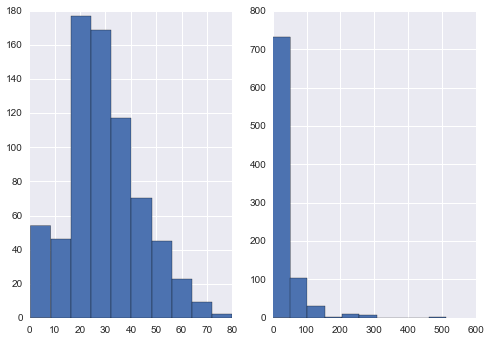

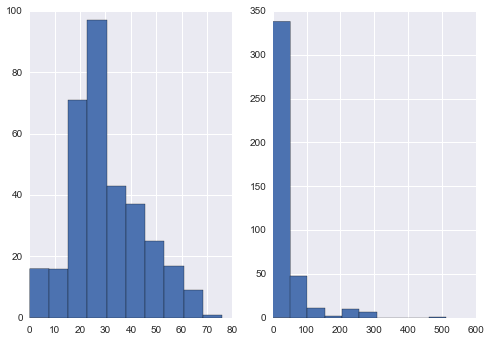

In [7]:
def get_title_type(title):
    title_map = {
        ('Mr.', 'Mrs.', 'Miss.', 'Ms.', 'Master.', 'Mme.', 'Mlle.'): 0, # pedestrian
        ('Don.', 'Dona.', 'the', 'Sir.', 'Lady.', 'Jonkheer.'):      1, # honorary
        ('Dr.'):                                                     2, # academic
        ('Rev.'):                                                    3, # religious
        ('Major.', 'Col.', 'Capt.'):                                 4  # military
    }
    for key in title_map:
        if title in key: return title_map[key]
    
def munge_data(filepath):
    df = pd.read_csv(filepath)
    
    df['Title'] = df['Name'].map( lambda x: get_title_type(x.split(',')[1].split()[0]) )
    
    df['Sex_enum'] = df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

    df = df.dropna(subset=['Embarked'])
    df['Embarked_enum'] = df['Embarked'].map( {'C': 0, 'Q': 1, 'S': 2} ).astype(int)
    
    fig, axs = plt.subplots(1,2)

    df['Age'].hist(ax=axs[0])
    df['Fare'].hist(ax=axs[1])

    median_ages = np.zeros((2,3))
    for i in range(0, 2):
        for j in range(0, 3):
            median_ages[i,j] = df[(df['Sex_enum'] == i) & (df['Pclass'] == j+1)]['Age'].dropna().median()
            
    median_fares = np.zeros((2,3))
    for i in range(0, 2):
        for j in range(0, 3):
            median_fares[i,j] = df[(df['Sex_enum'] == i) & (df['Pclass'] == j+1)]['Fare'].dropna().median()

    df['AgeFill'] = df['Age']
    for i in range(0, 2):
        for j in range(0, 3):
            df.loc[ (df.Age.isnull()) & (df.Sex_enum == i) & (df.Pclass == j+1), 'AgeFill'] = median_ages[i,j]
    
    df['FareFill'] = df['Fare']
    for i in range(0, 2):
        for j in range(0, 3):
            df.loc[ (df.Fare.isnull()) & (df.Sex_enum == i) & (df.Pclass == j+1), 'FareFill'] = median_fares[i,j]
    
    df['FamilySize'] = df['SibSp'] + df['Parch']
    df['Age*Class'] = df.AgeFill * df.Pclass

    df = df.drop(['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age', 'AgeFill', 'Fare'], axis=1)
    df.info()
    return df.values

train_data = munge_data('titanic/train.csv')
train_data

test_data = munge_data('titanic/test.csv')
test_data

In [ ]:
def evaluate(fold):
    # Evaluate a logistic regression classifier
    train_indices, test_indices = fold
    
    X_train = train_data[train_indices, 1:]
    Y_train = train_data[train_indices, 0]
    X_test = train_data[test_indices, 1:]
    Y_test = train_data[test_indices, 0]

    return linear_model.LogisticRegression().fit(X_train,Y_train).score(X_test, Y_test)

In [ ]:
from sklearn import datasets, linear_model, cross_validation, preprocessing

print np.mean([evaluate((train_i, test_i)) for train_i, test_in in cross_validation.KFold(len(X), n_folds=10)])

test_predictions = linear_model.LogisticRegression().fit(train_data[:,1:],train_data[:,0]).predict(test_data)

df = pd.read_csv('titanic/test.csv')
df = df.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked', 'Age', 'Fare', 'Pclass', 'SibSp', 'Parch'], axis=1)
df['Survived'] = test_predictions.astype(int)
df.to_csv('titanic/predictions.csv', index=False)